In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
from sklearn import set_config
set_config(display="diagram")
warnings.filterwarnings('ignore')
import pickle

# the next 4 cells are functions for calculating metrics/scores and plotting ROC or PR curves that are used frequently after each GridSearchCV run

In [2]:
###
### Computes all the scores from GridSearchCV and puts them into a nice dataframe
### this version is for multiclass one-vs-the-rest Classifiers not binary class problems
###
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

def make_multiclass_score( clf, X_train, y_train, X_test, y_test, clf_text ):
    y_test_pred = clf.predict( X_test )
    y_pred_proba = clf.predict_proba( X_test )

    train_score = clf.score( X_train, y_train)
    test_score = clf.score( X_test, y_test)

    auc = roc_auc_score( y_test, y_pred_proba, multi_class="ovr" )    

    cnf_mat = confusion_matrix( y_test, y_test_pred )
    # print(cnf_mat)

    FP = cnf_mat.sum(axis=0) - np.diag(cnf_mat) 
    FN = cnf_mat.sum(axis=1) - np.diag(cnf_mat)
    TP = np.diag(cnf_mat)
    TN = cnf_mat.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
# Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
# Specificity or true negative rate
    TNR = TN/(TN+FP) 
# Precision or positive predictive value
    PPV = TP/(TP+FP)
# Negative predictive value
    NPV = TN/(TN+FN)
# Fall out or false positive rate
    FPR = FP/(FP+TN)
# False negative rate
    FNR = FN/(TP+FN)
# False discovery rate
    FDR = FP/(TP+FP)
# Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print( f'accuracy {ACC}')
    print( f'precision {PPV}' )
    print( f'sensitivity/recall {TPR}' )
    print( f'specificity {TNR}' )
    
    spec = TN/(TN+FP) 
    acc  = accuracy_score( y_test, y_test_pred )
    prec = precision_score( y_test, y_test_pred, average='macro' )
    rec  = recall_score( y_test, y_test_pred, average='macro' )
    f1   = f1_score( y_test, y_test_pred, average='macro' )

    fit_time = np.mean( clf.cv_results_['mean_fit_time'])

   #  print(f'acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} fit_time={fit_time:.3f}')
    
    score_dict = {'CLF' : [clf_text], 
                  'train_score':[round(train_score,3)], 
                  'accuracy':[round(acc,3)], 
                  'precision':[round(prec,3)], 
                  'recall':[round(rec,3)], 
                  'f1':[round(f1,3)], 
                  'auc':[round(auc,3)],
                  'fit_time':[round(fit_time,3)] }
    df = pd.DataFrame(data=score_dict)
    print(df)
    print(classification_report(y_test, y_test_pred, target_names=['eq', 'ex', 'col']))
    return(df)

In [3]:
###
### Computes interpolated RO-Curves for macro and micro averages from multiclass classification
###
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

### n_classes = 3
### target_names = [ "eq", "ex", "co" ]

def multiclass_roc_curves( clf, target_names, X_train, y_train, X_test, y_test ):
    n_classes = len(target_names)
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    # print(y_onehot_test.shape)
    label_binarizer.transform([0, 1, 2])

    y_test_proba = clf.predict_proba( X_test )

##### store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

##### Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

#### Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

#### Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    fig, ax = plt.subplots(figsize=(5,5))

    plt.plot( fpr["micro"], tpr["micro"], 
             label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
             color="deeppink", linestyle=":", linewidth=4 )

    plt.plot( fpr["macro"], tpr["macro"], 
             label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
             color="navy", linestyle=":", linewidth=4 )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions( 
            y_onehot_test[:, class_id],
            y_test_proba[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color, ax=ax, )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.show()

In [4]:
###
### MULTICLASS CONFUSION MATRIX PLOT
###
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

def multiclass_confusion_matrix( clf, class_labels, X_test, y_test ):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix( y_test, y_pred, labels=clf.classes_ )
    disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=class_labels )          
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    plt.show()

In [5]:
###
### MULTICLASS PRECISION-RECALL PLOT
###
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

def multiclass_precision_recall( clf, class_labels, X_train, y_train, X_test, y_test ):
    n_classes = len(class_labels)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    label_binarizer.transform([0, 1, 2])

    # y_test_proba = clf.predict_proba( X_test )
    y_score = clf.decision_function( X_test )

### for each class
###
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve( y_onehot_test[:,i], y_score[:,i] ) 
        average_precision[i] = average_precision_score( y_onehot_test[:,i], y_score[:,i] ) 
    
#### A "micro-average": qunatifiying score on all classes jointly
####
    precision["micro"], recall["micro"], _ = precision_recall_curve( y_onehot_test.ravel(), y_score.ravel() )
    average_precision["micro"] = average_precision_score( y_onehot_test, y_score, average="micro" )

##### Plot the micro-averaged Precision-Recall curve
#####
# display = PrecisionRecallDisplay(
#    recall=recall["micro"],
#    precision=precision["micro"],
#    average_precision=average_precision["micro"] )
# 
# display.plot()
# _ = display.ax_.set_title("Micro-averaged over all classes")
#####

### Plot Precision-Recall curve for each class and iso-f1 curves
### setup plot details
###
    _, ax = plt.subplots(figsize=(5,5))
    
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
 
    display = PrecisionRecallDisplay( recall=recall["micro"], precision=precision["micro"], 
                                 average_precision=average_precision["micro"] )

    display.plot( ax = ax, name = "Micro-average P-R", color = "gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"P-R class {class_labels[i]}", color=color)

# add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    
# set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="lower left")
    ax.set_title("Extension of Precision-Recall (P-R) curve to multi-class")

    plt.show()

# Load the Data

In [6]:
### California Geyser "volcanic" earthquakes from Sierra Boyd et al. were not classified as explosions
# df = pd.read_csv( "data/ML_mt.csv" )
### here geyser quakes were labeled as explosions 
df = pd.read_csv( "data/ML_mt_geysers.csv")    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lune_lon     1440 non-null   float64
 1   lune_lat     1440 non-null   float64
 2   pvr          1440 non-null   float64
 3   pdc          1440 non-null   int64  
 4   pclvd        1440 non-null   int64  
 5   piso         1440 non-null   int64  
 6   Mo           1440 non-null   float64
 7   mxx          1440 non-null   float64
 8   myy          1440 non-null   float64
 9   mzz          1440 non-null   float64
 10  mxy          1440 non-null   float64
 11  mxz          1440 non-null   float64
 12  myz          1440 non-null   float64
 13  eig1         1440 non-null   float64
 14  eig2         1440 non-null   float64
 15  eig3         1440 non-null   float64
 16  origin_time  1440 non-null   object 
 17  lat          1440 non-null   float64
 18  lon          1440 non-null   float64
 19  momag 

In [7]:
df.head(5)

,lune_lon,lune_lat,pvr,pdc,pclvd,piso,Mo,mxx,myy,mzz,...,eig3,origin_time,lat,lon,momag,depth,evid,auth,region,label
0,-12.1688,12.4622,60.0,48,38,14,1.004000e+20,-0.1206,0.5958,-0.052210,...,1.0000,1992-04-26T07:41:40.09,40.432,-124.566,6.47,1.5,645371,BSL_Lombard,NEAR COAST OF NORTHERN CALIF.,0
1,16.4414,-19.1274,81.0,33,47,20,1.023000e+20,-0.8817,0.2737,0.003646,...,-1.0000,1992-04-26T11:18:25.98,40.383,-124.555,6.50,39.0,645382,BSL_Lombard,NEAR COAST OF NORTHERN CALIF.,0
2,19.4029,56.1160,69.0,16,33,52,1.421000e+17,0.2357,0.5629,0.752900,...,0.8368,1992-09-19T23:04:46.83,38.860,-122.792,4.61,5.0,653173,BSL_Lombard,NORTHERN CALIFORNIA,0
3,3.0489,58.5634,75.0,38,5,57,1.882000e+16,0.2226,0.6801,0.791700,...,0.9740,1993-01-18T23:27:10.61,38.842,-122.778,4.05,11.0,658947,BSL_Lombard,NORTHERN CALIFORNIA,0
4,10.4351,62.0630,68.0,26,16,59,1.047000e+16,0.2616,0.5843,0.911900,...,0.1719,1993-01-19T00:24:29.20,38.846,-122.777,3.88,11.0,658952,BSL_Lombard,NORTHERN CALIFORNIA,0


In [8]:
# add a event-type "etype" column in dataframe for plot labels
#
event_dict = { 0:'eq', 1:'ex', 2:'co' }
df['etype'] = df['label'].map(event_dict)

In [9]:
# Class imbalance: 
# Earthquakes   82.4% 
# Explosions    14.3% 
# Mine Collapses 3.3%  
#
print(len(df), df.shape)
df.groupby("etype")['etype'].count()/len(df)

1440 (1440, 26)


etype
co    0.033333
eq    0.823611
ex    0.143056
Name: etype, dtype: float64

In [10]:
df[['mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz', 'eig1', 'eig2', 'eig3']].describe()

,mxx,myy,mzz,mxy,mxz,myz,eig1,eig2,eig3
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,-0.113497,0.358150,0.068749,-0.034449,-0.017982,0.023640,0.098059,0.121860,0.093487
std,0.518404,0.457696,0.512899,0.366938,0.252813,0.233605,0.677011,0.468342,0.828708
min,-0.991400,-0.994300,-0.998900,-0.929700,-0.941800,-0.798800,-1.000000,-1.000000,-1.000000
25%,-0.540075,0.095588,-0.251675,-0.283475,-0.167525,-0.116825,-0.527575,-0.158375,-0.797150
50%,-0.158300,0.432150,0.048325,-0.031360,-0.000499,0.028235,0.158950,0.113800,0.225250
75%,0.308025,0.728150,0.393650,0.157750,0.134425,0.165425,0.751800,0.382650,0.999775
max,0.999900,0.999000,0.999800,0.958300,0.904900,0.807200,1.000000,1.000000,1.000000


          lune_lat  lune_lon      eig1      eig2      eig3     label
lune_lat  1.000000 -0.459587  0.351039  0.474907  0.495914  0.177268
lune_lon -0.459587  1.000000 -0.003108  0.070986 -0.498022 -0.049500
eig1      0.351039 -0.003108  1.000000  0.099220 -0.497361  0.054804
eig2      0.474907  0.070986  0.099220  1.000000 -0.137325  0.059154
eig3      0.495914 -0.498022 -0.497361 -0.137325  1.000000  0.100827
label     0.177268 -0.049500  0.054804  0.059154  0.100827  1.000000


<AxesSubplot:>

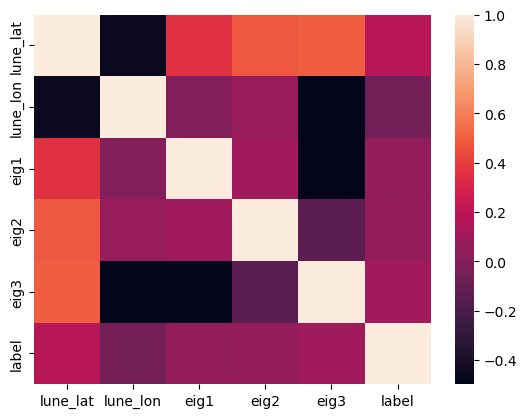

In [11]:
cor = df[['lune_lat', 'lune_lon', 'eig1', 'eig2', 'eig3', 'label']].corr()
print(cor)
sns.heatmap(cor)

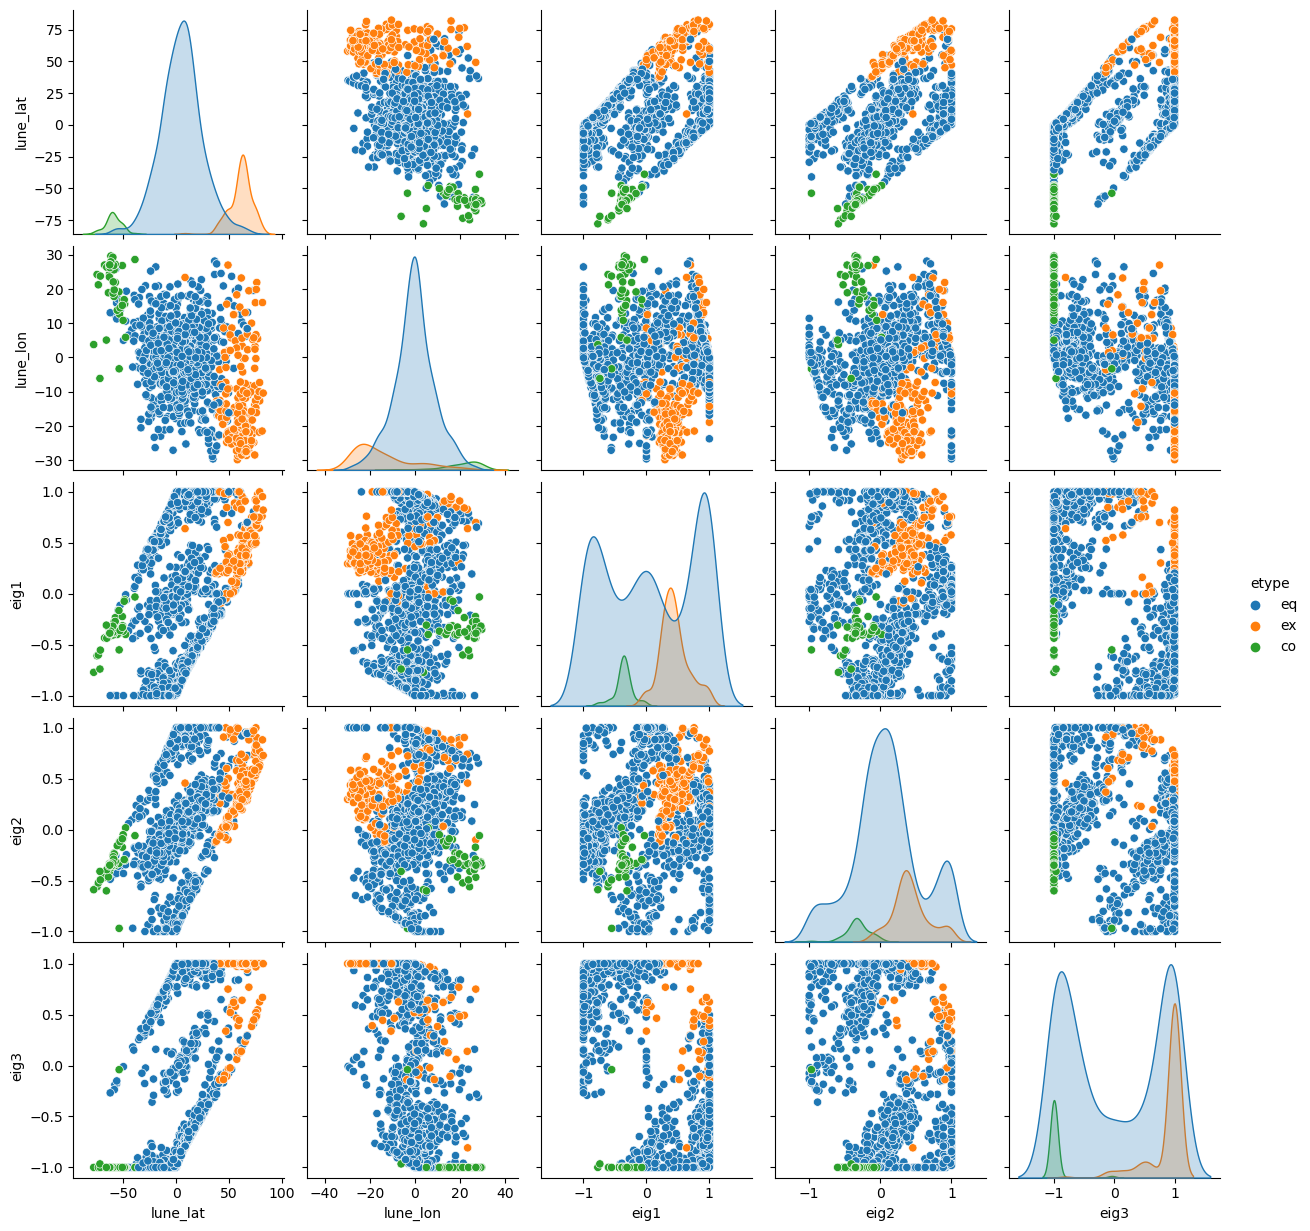

In [12]:
sns.pairplot( data = df[['lune_lat', 'lune_lon', 'eig1', 'eig2', 'eig3', 'etype']], hue='etype' )

<AxesSubplot:xlabel='lune_lon', ylabel='lune_lat'>

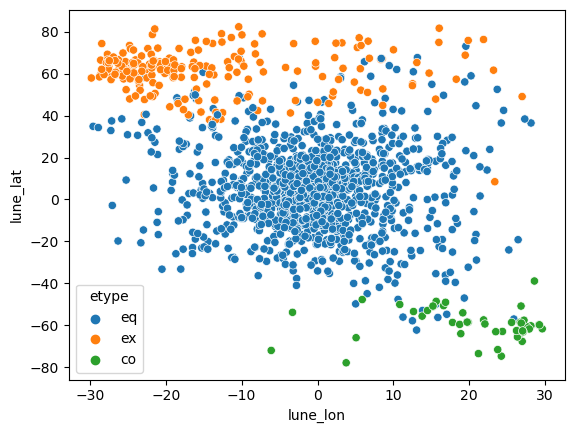

In [13]:
sns.scatterplot( data=df, y='lune_lat', x='lune_lon', hue='etype')

In [14]:
### We iterated with 3 sets of features.  The first two sets did not do well.  
### The most logical approach was to classify using just lune_lat and lune_lon
#
#features = ['lune_lat', 'lune_lon', 'eig1', 'eig2', 'eig3', 'mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz']
#features = ['lune_lat', 'lune_lon', 'eig1', 'eig2', 'eig3' ]
features = ['lune_lat', 'lune_lon']
X_orig = df[features]
y =  df[['label']]

# train test split, used 40% test 

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X_orig, y, test_size=0.4, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(864, 2)
(576, 2)
(864, 1)
(576, 1)


# Support Vector Machine Classifier (SVC)

In [16]:
svc_clf = OneVsRestClassifier(SVC(probability=True, class_weight='balanced'))

svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svc_clf ) 
])

# "svc__estimator__kernel" : [ 'rbf', 'poly' ]
# "svc__estimator__degree" : [ 1, 2, 3, 4 ],
#  "svc__estimator__gamma"  : [  0.001, 0.01, 0.1, 0.3, 1, 3, 10, 30, 100, 300 ],

params_svc = {
    "svc__estimator__C"      : [ 0.01, 0.1, 1, 10, 30, 100, 300 ], 
    "svc__estimator__gamma"  : [ 0.001, 0.01, 0.1, 1, 10 ],
    "svc__estimator__kernel" : [ 'rbf' ]
}

In [17]:
svc_grid = GridSearchCV( svc_pipe, param_grid=params_svc, cv=5, scoring='balanced_accuracy', verbose=1)
svc_grid.fit( X_train, y_train )
print(svc_grid.best_estimator_)
print(f'best param={svc_grid.best_params_}  best score={svc_grid.best_score_:.3f}')

filename = 'output/svc_grid.sav'
pickle.dump(svc_grid, open(filename,'wb'))

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 OneVsRestClassifier(estimator=SVC(C=30,
                                                   class_weight='balanced',
                                                   gamma=0.01,
                                                   probability=True)))])
best param={'svc__estimator__C': 30, 'svc__estimator__gamma': 0.01, 'svc__estimator__kernel': 'rbf'}  best score=0.980


In [18]:
# Save the estimator for later classification predictions
#
filename = 'output/svc_grid.sav'
load_svc_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_scores = make_multiclass_score( load_svc_grid, X_train, y_train, X_test, y_test, "SVC" )
df_scores

accuracy [0.93923611 0.94965278 0.98958333]
precision [0.99310345 0.76146789 0.8125    ]
sensitivity/recall [0.93103448 0.96511628 1.        ]
specificity [0.97321429 0.94693878 0.98909091]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  SVC         0.98     0.939      0.856   0.965  0.903  0.987      0.12
              precision    recall  f1-score   support

          eq       0.99      0.93      0.96       464
          ex       0.76      0.97      0.85        86
         col       0.81      1.00      0.90        26

    accuracy                           0.94       576
   macro avg       0.86      0.97      0.90       576
weighted avg       0.95      0.94      0.94       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,SVC,0.98,0.939,0.856,0.965,0.903,0.987,0.12


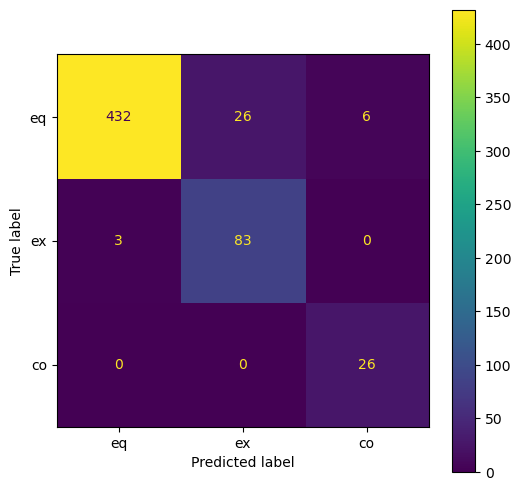

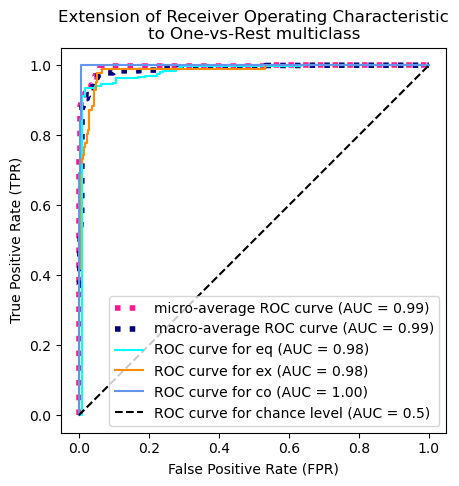

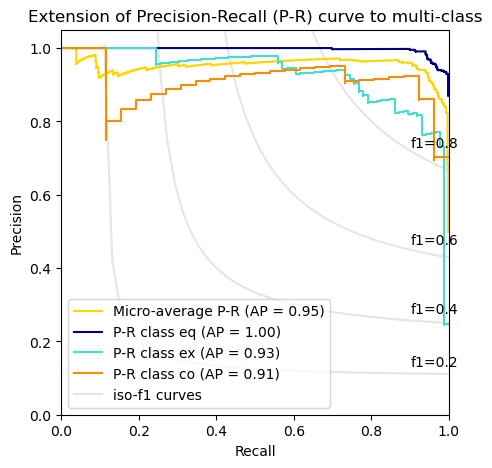

In [19]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_svc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_svc_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_svc_grid, class_labels, X_train, y_train, X_test, y_test )

# DecisionTreeClassifier

In [20]:
dtc_clf = OneVsRestClassifier(DecisionTreeClassifier(class_weight="balanced"))

dtc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dtc', dtc_clf ) 
])

params_dtc = {
    "dtc__estimator__ccp_alpha" : [ 0.001, 0.003, 0.01, 0.03, 0.1 ],
    "dtc__estimator__criterion" : [ "gini", "entropy" ],
    "dtc__estimator__max_depth"  :        [ 10, 20, 40 ],
    "dtc__estimator__min_samples_split" : [ 2, 3, 4, 5 ],
    "dtc__estimator__splitter" : [ "best", "random" ]
}
# best param={
#   'dtc__estimator__ccp_alpha': 0.01, 
#   'dtc__estimator__criterion': 'gini', 
#   'dtc__estimator__max_depth': 20, 
#   'dtc__estimator__min_samples_split': 3, 
#   'dtc__estimator__splitter': 'random'}  best score=0.939

In [21]:
dtc_grid = GridSearchCV( dtc_pipe, param_grid=params_dtc, cv=5, scoring='balanced_accuracy', verbose=1)
dtc_grid.fit( X_train, y_train )
print(dtc_grid.best_estimator_)
print(f'best param={dtc_grid.best_params_}  best score={dtc_grid.best_score_:.3f}')

filename = 'output/dtc_grid.sav'
pickle.dump(dtc_grid, open(filename,'wb'))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('dtc',
                 OneVsRestClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.03,
                                                                      class_weight='balanced',
                                                                      criterion='entropy',
                                                                      max_depth=10,
                                                                      splitter='random')))])
best param={'dtc__estimator__ccp_alpha': 0.03, 'dtc__estimator__criterion': 'entropy', 'dtc__estimator__max_depth': 10, 'dtc__estimator__min_samples_split': 2, 'dtc__estimator__splitter': 'random'}  best score=0.980


In [22]:
# Save the estimator for later classification predictions
#
filename = 'output/dtc_grid.sav'
load_dtc_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_tmp = make_multiclass_score( load_dtc_grid, X_train, y_train, X_test, y_test, "DTC" )
df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.89409722 0.92708333 0.96701389]
precision [0.995086   0.67460317 0.58139535]
sensitivity/recall [0.87284483 0.98837209 0.96153846]
specificity [0.98214286 0.91632653 0.96727273]
   CLF  train_score  accuracy  precision  recall     f1   auc  fit_time
0  DTC        0.966     0.894       0.75   0.941  0.819  0.98     0.006
              precision    recall  f1-score   support

          eq       1.00      0.87      0.93       464
          ex       0.67      0.99      0.80        86
         col       0.58      0.96      0.72        26

    accuracy                           0.89       576
   macro avg       0.75      0.94      0.82       576
weighted avg       0.93      0.89      0.90       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


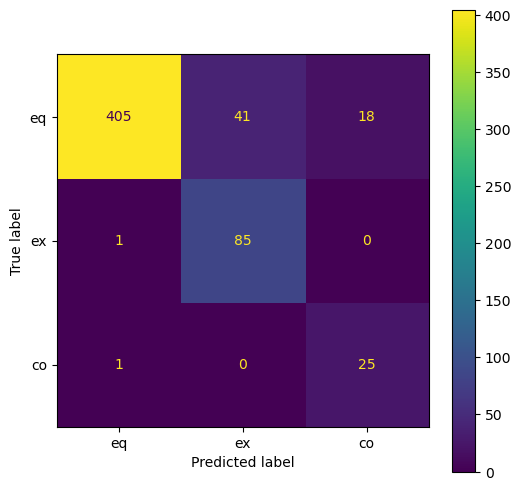

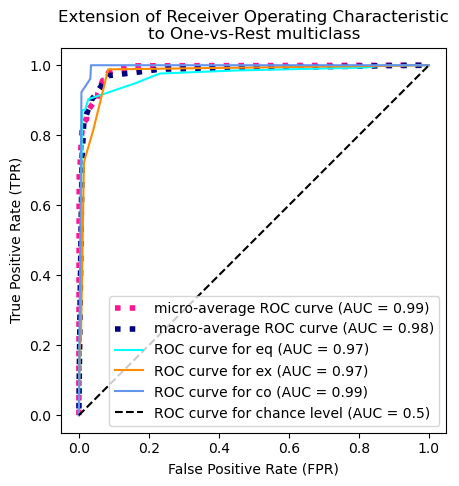

In [23]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_dtc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_dtc_grid, class_labels, X_train, y_train, X_test, y_test )

### DecisionTreeClassifiers do not have a decision_function() method only predict() and predict_proba()
#
# multiclass_precision_recall( load_dtc_grid, class_labels, X_train, y_train, X_test, y_test )

# KNeighborsClassifier

In [24]:
knn_clf = OneVsRestClassifier(KNeighborsClassifier())

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn_clf ) 
])

params_knn = {
    "knn__estimator__algorithm"  : [  "auto", "ball_tree", "kd_tree", "brute" ],
    "knn__estimator__leaf_size" : [ 1, 2, 3, 4, 5, 6 ],
    "knn__estimator__n_neighbors" : [ 15, 20, 25, 30 ],
    "knn__estimator__weights" : [ "uniform", "distance" ]
}
# best param={'knn__estimator__algorithm': 'auto', 'knn__estimator__leaf_size': 5, 
# 'knn__estimator__n_neighbors': 10, 'knn__estimator__weights': 'distance'}  best score=0.861

In [25]:
knn_grid = GridSearchCV( knn_pipe, param_grid=params_knn, cv=5, scoring='balanced_accuracy', verbose=1)
knn_grid.fit( X_train, y_train )
print( knn_grid.best_estimator_)
print(f'best param={knn_grid.best_params_}  best score={knn_grid.best_score_:.3f}')

filename = 'output/knn_grid.sav'
pickle.dump(knn_grid, open(filename,'wb'))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 OneVsRestClassifier(estimator=KNeighborsClassifier(leaf_size=1,
                                                                    n_neighbors=15,
                                                                    weights='distance')))])
best param={'knn__estimator__algorithm': 'auto', 'knn__estimator__leaf_size': 1, 'knn__estimator__n_neighbors': 15, 'knn__estimator__weights': 'distance'}  best score=0.920


In [26]:
# Save the estimator for later classification predictions
#
filename = 'output/knn_grid.sav'
load_knn_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_tmp = make_multiclass_score( load_knn_grid, X_train, y_train, X_test, y_test, "KNN" )
df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.93229167 0.94444444 0.98784722]
precision [0.94736842 0.85526316 0.88      ]
sensitivity/recall [0.96982759 0.75581395 0.84615385]
specificity [0.77678571 0.97755102 0.99454545]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  KNN          1.0     0.932      0.894   0.857  0.875  0.986     0.005
              precision    recall  f1-score   support

          eq       0.95      0.97      0.96       464
          ex       0.86      0.76      0.80        86
         col       0.88      0.85      0.86        26

    accuracy                           0.93       576
   macro avg       0.89      0.86      0.87       576
weighted avg       0.93      0.93      0.93       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


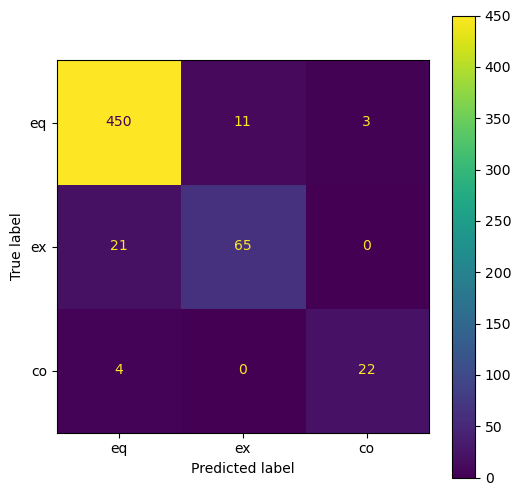

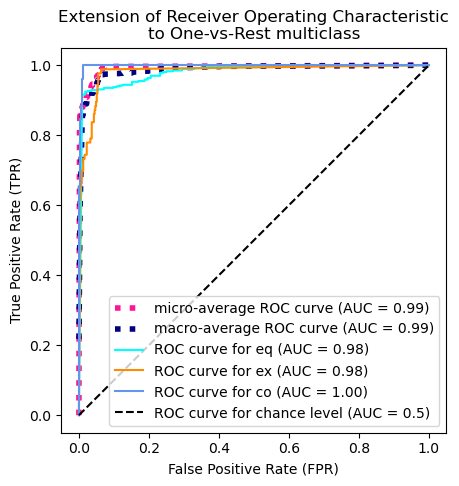

In [27]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_knn_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_knn_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_knn_grid, class_labels, X_train, y_train, X_test, y_test )

# LogisticRegression

In [28]:
lgr_clf = OneVsRestClassifier(LogisticRegression(class_weight="balanced", multi_class='ovr'))

lgr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lgr', lgr_clf ) 
])

params_lgr = {
    "lgr__estimator__C" : [ 0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100 ], 
    "lgr__estimator__penalty" : [ "l1", "l2" ],
    "lgr__estimator__solver"  : [  "lbfgs", "liblinear", "newton-cg", "sag", "saga" ]
}

In [29]:
lgr_grid = GridSearchCV( lgr_pipe, param_grid=params_lgr, cv=5, scoring='balanced_accuracy', verbose=1)
lgr_grid.fit( X_train, y_train )
print( lgr_grid.best_estimator_)
print(f'best param={lgr_grid.best_params_}  best score={lgr_grid.best_score_:.3f}')

filename = 'output/lgr_grid.sav'
pickle.dump(lgr_grid, open(filename,'wb'))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('lgr',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.3,
                                                                  class_weight='balanced',
                                                                  multi_class='ovr',
                                                                  penalty='l1',
                                                                  solver='saga')))])
best param={'lgr__estimator__C': 0.3, 'lgr__estimator__penalty': 'l1', 'lgr__estimator__solver': 'saga'}  best score=0.975


In [30]:
# Save the estimator for later classification predictions
#
filename = 'output/lgr_grid.sav'
load_lgr_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_tmp = make_multiclass_score( load_lgr_grid, X_train, y_train, X_test, y_test, "LGR" )
df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.94097222 0.94965278 0.99131944]
precision [0.99311927 0.75675676 0.86206897]
sensitivity/recall [0.93318966 0.97674419 0.96153846]
specificity [0.97321429 0.94489796 0.99272727]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  LGR        0.983     0.941      0.871   0.957  0.908  0.982     0.009
              precision    recall  f1-score   support

          eq       0.99      0.93      0.96       464
          ex       0.76      0.98      0.85        86
         col       0.86      0.96      0.91        26

    accuracy                           0.94       576
   macro avg       0.87      0.96      0.91       576
weighted avg       0.95      0.94      0.94       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


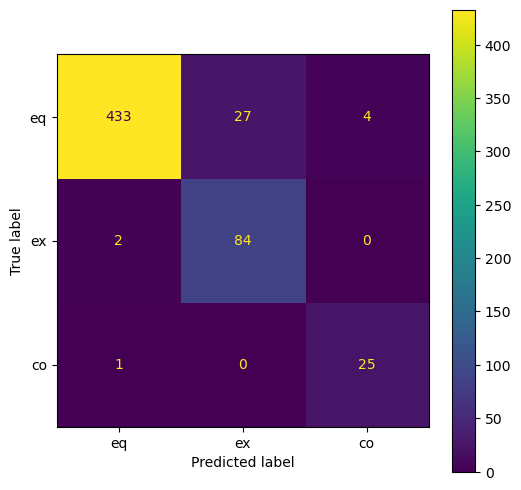

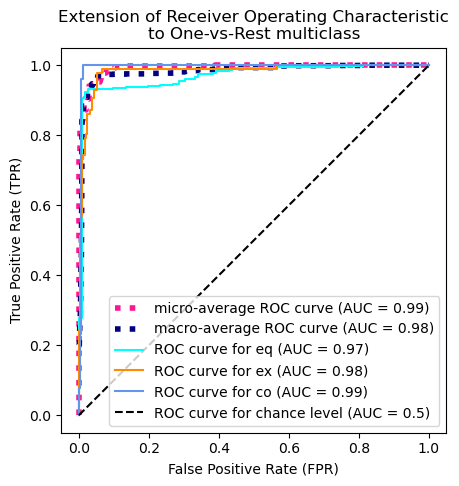

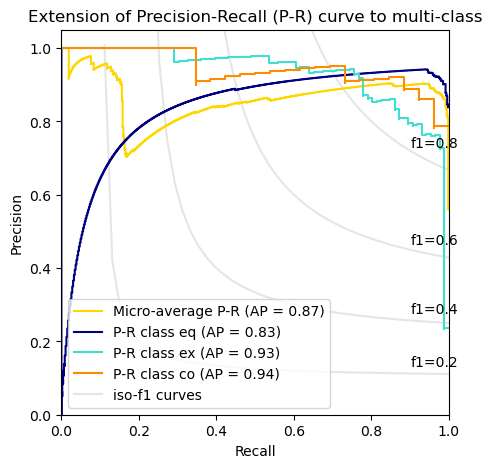

In [31]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_lgr_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_lgr_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_lgr_grid, class_labels, X_train, y_train, X_test, y_test )

# RandomForestClassifier 

In [32]:
rfc_clf = OneVsRestClassifier(RandomForestClassifier(class_weight="balanced"))

rfc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', rfc_clf ) 
])

params_rfc = {
    "rfc__estimator__ccp_alpha" : [ 0.001, 0.003, 0.01, 0.03, 0.1 ],
    "rfc__estimator__criterion" : [ "gini" ], 
    "rfc__estimator__max_depth"  : [ 10, 20, 40 ],
    "rfc__estimator__min_samples_split" : [ 2, 3, 4 ],
    "rfc__estimator__n_estimators" : [ 100, 200 ]
}

# best param={
# 'rfc__estimator__ccp_alpha': 0.01, 'rfc__estimator__criterion': 'gini', 
# 'rfc__estimator__max_depth': 10, 'rfc__estimator__min_samples_split': 3, 
# 'rfc__estimator__n_estimators': 100}  best score=0.929


In [33]:
rfc_grid = GridSearchCV( rfc_pipe, param_grid=params_rfc, cv=5, scoring='balanced_accuracy', verbose=1)
rfc_grid.fit( X_train, y_train )
print( rfc_grid.best_estimator_)
print(f'best param={rfc_grid.best_params_}  best score={rfc_grid.best_score_:.3f}')

filename = 'output/rfc_grid.sav'
pickle.dump(rfc_grid, open(filename,'wb'))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc',
                 OneVsRestClassifier(estimator=RandomForestClassifier(ccp_alpha=0.01,
                                                                      class_weight='balanced',
                                                                      max_depth=10,
                                                                      min_samples_split=3)))])
best param={'rfc__estimator__ccp_alpha': 0.01, 'rfc__estimator__criterion': 'gini', 'rfc__estimator__max_depth': 10, 'rfc__estimator__min_samples_split': 3, 'rfc__estimator__n_estimators': 100}  best score=0.961


In [34]:
filename = 'output/rfc_grid.sav'
load_rfc_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_rfc_grid, X_train, y_train, X_test, y_test, "RFC" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.94270833 0.95138889 0.99131944]
precision [0.98866213 0.77358491 0.86206897]
sensitivity/recall [0.93965517 0.95348837 0.96153846]
specificity [0.95535714 0.95102041 0.99272727]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  RFC        0.985     0.943      0.875   0.952  0.909  0.986     0.427
              precision    recall  f1-score   support

          eq       0.99      0.94      0.96       464
          ex       0.77      0.95      0.85        86
         col       0.86      0.96      0.91        26

    accuracy                           0.94       576
   macro avg       0.87      0.95      0.91       576
weighted avg       0.95      0.94      0.94       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
0,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


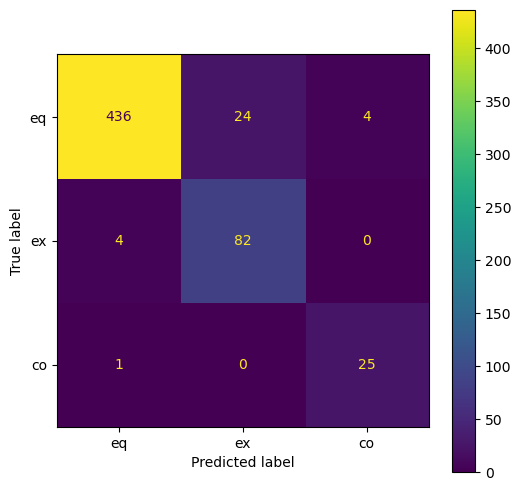

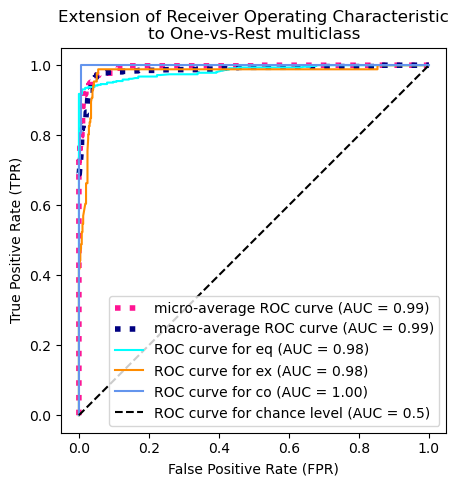

In [35]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_rfc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_rfc_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_rfc_grid, class_labels, X_train, y_train, X_test, y_test )

# GaussianProcessClassifier

In [36]:
gpc_clf = OneVsRestClassifier(GaussianProcessClassifier(multi_class="one_vs_rest"))

gpc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gpc', gpc_clf ) 
])

params_gpc = { }

In [37]:
gpc_grid = GridSearchCV( gpc_pipe, param_grid=params_gpc, cv=5, scoring='balanced_accuracy', verbose=3)
gpc_grid.fit( X_train, y_train )
print( gpc_grid.best_estimator_)
print(f'best param={gpc_grid.best_params_}  best score={gpc_grid.best_score_:.3f}')

filename = 'output/gpc_grid.sav'
pickle.dump(gpc_grid, open(filename,'wb'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.817 total time=   0.7s
[CV 2/5] END ..................................., score=0.958 total time=   0.6s
[CV 3/5] END ..................................., score=0.963 total time=   0.7s
[CV 4/5] END ..................................., score=0.816 total time=   0.8s
[CV 5/5] END ..................................., score=0.785 total time=   0.8s
Pipeline(steps=[('scaler', StandardScaler()),
                ('gpc',
                 OneVsRestClassifier(estimator=GaussianProcessClassifier()))])
best param={}  best score=0.868


In [38]:
filename = 'output/gpc_grid.sav'
load_gpc_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_gpc_grid, X_train, y_train, X_test, y_test, "GPC" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.92881944 0.94270833 0.98611111]
precision [0.94339623 0.84415584 0.90909091]
sensitivity/recall [0.96982759 0.75581395 0.76923077]
specificity [0.75892857 0.9755102  0.99636364]
   CLF  train_score  accuracy  precision  recall     f1   auc  fit_time
0  GPC        0.905     0.929      0.899   0.832  0.862  0.99     0.676
              precision    recall  f1-score   support

          eq       0.94      0.97      0.96       464
          ex       0.84      0.76      0.80        86
         col       0.91      0.77      0.83        26

    accuracy                           0.93       576
   macro avg       0.90      0.83      0.86       576
weighted avg       0.93      0.93      0.93       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
0,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
0,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


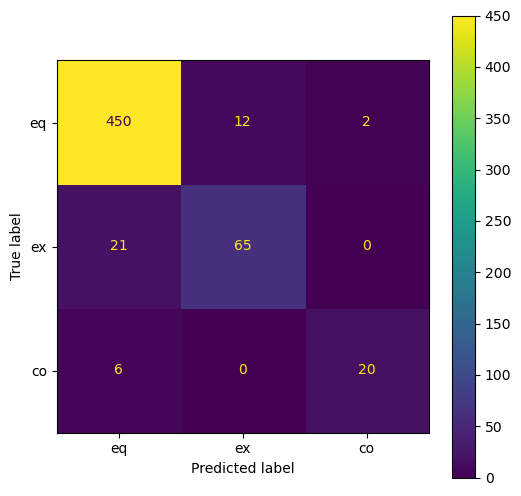

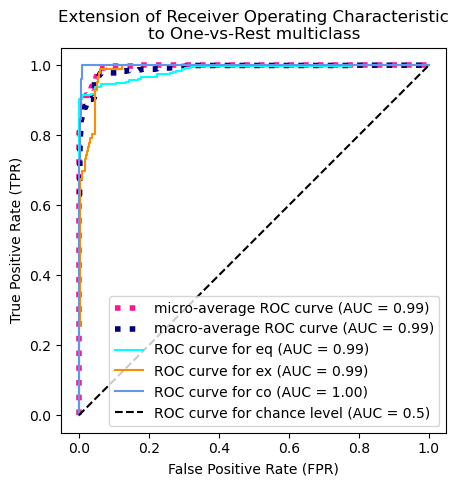

In [39]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_gpc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_gpc_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_gpc_grid, class_labels, X_train, y_train, X_test, y_test )

# MLPClassifier

In [40]:
#Multilayer Perceptron classifier
mlp_clf = OneVsRestClassifier(MLPClassifier(max_iter=100))

mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp_clf ) 
])

# "mlp__estimator__activation" : [ "identity", "logistic", "tanh", "relu" ],
# "mlp__estimator__learning_rate" : [ "constant", "invscaling", "adaptive" ],
# "mlp__estimator__hidden_layer_sizes" : [ 100, 300, 1000 ],
# "mlp__estimator__alpha" : [ 0.01, 0.1, 0.3, 1, 3, 10, 100 ],
# "mlp__estimator__learning_rate_init" : [ 0.001, 0.01, 0.1 ]
#
params_mlp = { 
    "mlp__estimator__activation" : [  "tanh" ],
    "mlp__estimator__alpha" : [  0.01, 0.1, 1, 10, 100 ],
    "mlp__estimator__hidden_layer_sizes" : [ 500 ],
    "mlp__estimator__learning_rate" : [ "adaptive" ],
    "mlp__estimator__learning_rate_init" : [ 0.001, 0.01, 0.1 ],
    "mlp__estimator__solver" : [ "lbfgs", "adam" ]
}

In [41]:
mlp_grid = GridSearchCV( mlp_pipe, param_grid=params_mlp, cv=5, scoring='balanced_accuracy', verbose=1)
mlp_grid.fit( X_train, y_train )
print( mlp_grid.best_estimator_)
print(f'best param={mlp_grid.best_params_}  best score={mlp_grid.best_score_:.3f}')

filename = 'output/mlp_grid.sav'
pickle.dump(mlp_grid, open(filename,'wb'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 OneVsRestClassifier(estimator=MLPClassifier(activation='tanh',
                                                             alpha=0.01,
                                                             hidden_layer_sizes=500,
                                                             learning_rate='adaptive',
                                                             learning_rate_init=0.1,
                                                             max_iter=100)))])
best param={'mlp__estimator__activation': 'tanh', 'mlp__estimator__alpha': 0.01, 'mlp__estimator__hidden_layer_sizes': 500, 'mlp__estimator__learning_rate': 'adaptive', 'mlp__estimator__learning_rate_init': 0.1, 'mlp__estimator__solver': 'adam'}  best score=0.911


In [42]:
filename = 'output/mlp_grid.sav'
load_mlp_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_mlp_grid, X_train, y_train, X_test, y_test, "MLP" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.93576389 0.94965278 0.98611111]
precision [0.94947368 0.86075949 0.90909091]
sensitivity/recall [0.97198276 0.79069767 0.76923077]
specificity [0.78571429 0.97755102 0.99636364]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  MLP        0.884     0.936      0.906   0.844  0.873  0.988     2.175
              precision    recall  f1-score   support

          eq       0.95      0.97      0.96       464
          ex       0.86      0.79      0.82        86
         col       0.91      0.77      0.83        26

    accuracy                           0.94       576
   macro avg       0.91      0.84      0.87       576
weighted avg       0.93      0.94      0.93       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
0,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
0,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
0,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


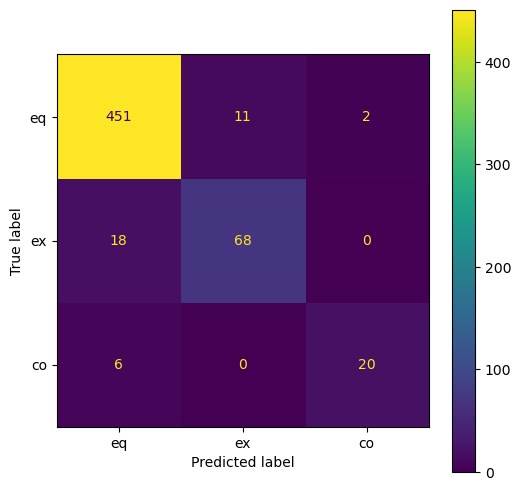

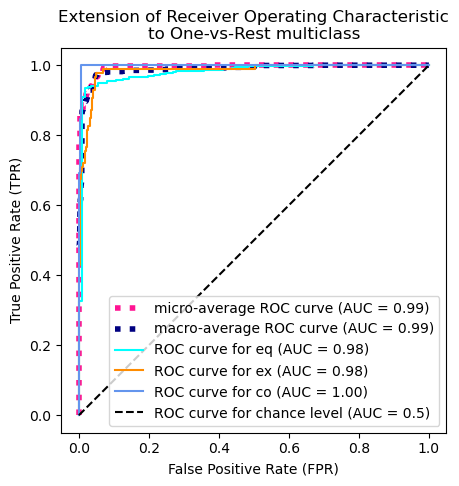

In [43]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_mlp_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_mlp_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_mlp_grid, class_labels, X_train, y_train, X_test, y_test )

# AdaBoostClassifier

In [44]:
abc_clf = OneVsRestClassifier(AdaBoostClassifier())

abc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('abc', abc_clf ) 
])
    
learning_rates = list(np.logspace( -5, -1, 10, base=10, endpoint=True ))
print(f'learning_rates={learning_rates}')

params_abc = {
    "abc__estimator__algorithm" : [ "SAMME", "SAMME.R" ],
    "abc__estimator__learning_rate" : learning_rates,
    "abc__estimator__n_estimators" : [ 1, 2, 4, 8, 12, 16 ]
}

learning_rates=[1e-05, 2.782559402207126e-05, 7.742636826811278e-05, 0.00021544346900318823, 0.0005994842503189409, 0.0016681005372000592, 0.004641588833612777, 0.012915496650148827, 0.03593813663804626, 0.1]


In [45]:
abc_grid = GridSearchCV( abc_pipe, param_grid=params_abc, cv=5, scoring='balanced_accuracy', verbose=1)
abc_grid.fit( X_train, y_train )
print( abc_grid.best_estimator_)
print(f'best param={abc_grid.best_params_}  best score={abc_grid.best_score_:.3f}')

filename = 'output/abc_grid.sav'
pickle.dump(abc_grid, open(filename,'wb'))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('abc',
                 OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                                  learning_rate=1e-05,
                                                                  n_estimators=1)))])
best param={'abc__estimator__algorithm': 'SAMME', 'abc__estimator__learning_rate': 1e-05, 'abc__estimator__n_estimators': 1}  best score=0.956


In [46]:
filename = 'output/abc_grid.sav'
load_abc_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_abc_grid, X_train, y_train, X_test, y_test, "ABC" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.94270833 0.95138889 0.99131944]
precision [0.97995546 0.79591837 0.86206897]
sensitivity/recall [0.94827586 0.90697674 0.96153846]
specificity [0.91964286 0.95918367 0.99272727]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  ABC        0.976     0.943      0.879   0.939  0.907  0.948     0.029
              precision    recall  f1-score   support

          eq       0.98      0.95      0.96       464
          ex       0.80      0.91      0.85        86
         col       0.86      0.96      0.91        26

    accuracy                           0.94       576
   macro avg       0.88      0.94      0.91       576
weighted avg       0.95      0.94      0.94       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
0,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
0,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
0,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
0,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


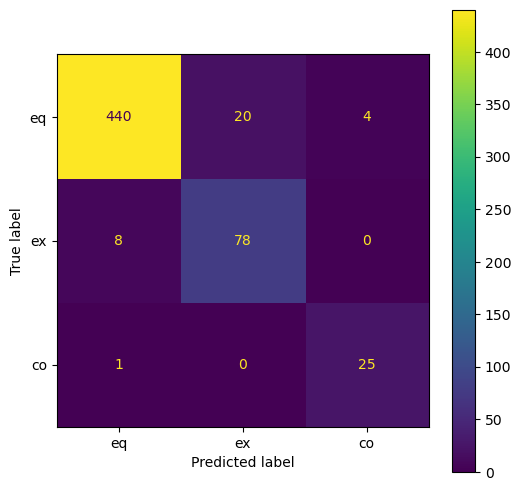

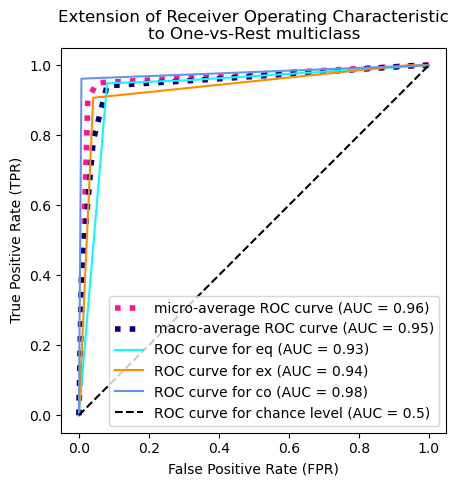

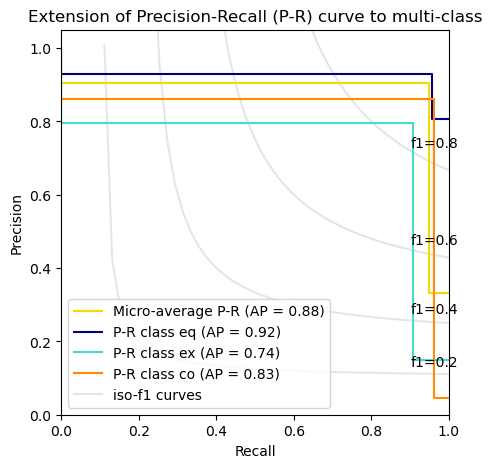

In [47]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_abc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_abc_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_abc_grid, class_labels, X_train, y_train, X_test, y_test )

# GaussianNB

In [48]:
gnb_clf = OneVsRestClassifier(GaussianNB())

gnb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', gnb_clf ) 
])

factors = list(np.logspace( -12, 1, 26, base=10, endpoint=True ))
print(f'smoothing factors={factors}')

params_gnb = {
    "gnb__estimator__var_smoothing" : factors
}

smoothing factors=[1e-12, 3.3113112148259077e-12, 1.0964781961431828e-11, 3.6307805477010174e-11, 1.2022644346174132e-10, 3.9810717055349694e-10, 1.31825673855641e-09, 4.365158322401665e-09, 1.4454397707459279e-08, 4.78630092322638e-08, 1.584893192461114e-07, 5.248074602497734e-07, 1.7378008287493763e-06, 5.754399373371567e-06, 1.9054607179632484e-05, 6.309573444801943e-05, 0.0002089296130854041, 0.0006918309709189362, 0.00229086765276777, 0.0075857757502918515, 0.025118864315095822, 0.08317637711026708, 0.27542287033381746, 0.9120108393559115, 3.019951720402019, 10.0]


In [49]:
# gnb_grid = GridSearchCV( gnb_pipe, param_grid=params_gnb, cv=5, scoring='recall_macro', verbose=1)
gnb_grid = GridSearchCV( gnb_pipe, param_grid=params_gnb, cv=5, scoring='balanced_accuracy', verbose=1)
gnb_grid.fit( X_train, y_train )
print( gnb_grid.best_estimator_)
print(f'best param={gnb_grid.best_params_}  best score={gnb_grid.best_score_:.3f}')

filename = 'output/gnb_grid.sav'
pickle.dump(gnb_grid, open(filename,'wb'))

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('gnb',
                 OneVsRestClassifier(estimator=GaussianNB(var_smoothing=1e-12)))])
best param={'gnb__estimator__var_smoothing': 1e-12}  best score=0.929


In [50]:
filename = 'output/gnb_grid.sav'
load_gnb_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_gnb_grid, X_train, y_train, X_test, y_test, "GNB" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.93576389 0.94618056 0.98958333]
precision [0.96112311 0.81609195 0.88461538]
sensitivity/recall [0.95905172 0.8255814  0.88461538]
specificity [0.83928571 0.96734694 0.99454545]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  GNB        0.947     0.936      0.887    0.89  0.889  0.987     0.005
              precision    recall  f1-score   support

          eq       0.96      0.96      0.96       464
          ex       0.82      0.83      0.82        86
         col       0.88      0.88      0.88        26

    accuracy                           0.94       576
   macro avg       0.89      0.89      0.89       576
weighted avg       0.94      0.94      0.94       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
0,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
0,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
0,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
0,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
0,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


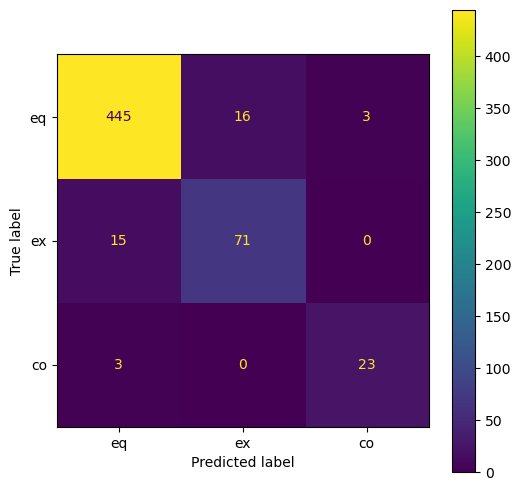

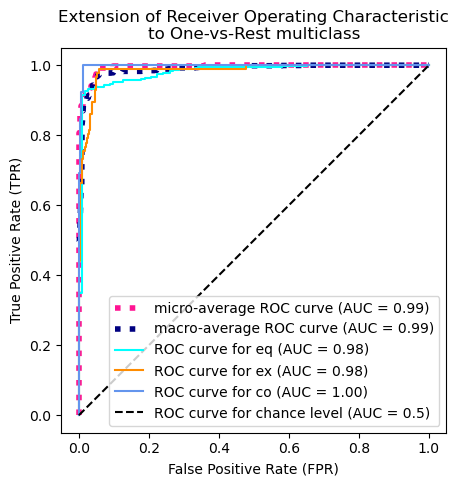

In [51]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_gnb_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_gnb_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_gnb_grid, class_labels, X_train, y_train, X_test, y_test )

# QuadraticDiscriminantAnalysis

In [52]:
qda_clf = OneVsRestClassifier(QuadraticDiscriminantAnalysis())

qda_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', qda_clf ) 
])

factors = list(np.logspace( -10, 1, 12, base=10, endpoint=True ))
print(f'regularization params={factors}')

params_qda = {
    "qda__estimator__reg_param" :  factors 
}

regularization params=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]


In [53]:
# qda_grid = GridSearchCV( qda_pipe, param_grid=params_qda, cv=5, scoring='precision_weighted', verbose=1)
qda_grid = GridSearchCV( qda_pipe, param_grid=params_qda, cv=5, scoring='balanced_accuracy', verbose=1)
qda_grid.fit( X_train, y_train )
print( qda_grid.best_estimator_)
print(f'best param={qda_grid.best_params_}  best score={qda_grid.best_score_:.3f}')

filename = 'output/qda_grid.sav'
pickle.dump(qda_grid, open(filename,'wb'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('qda',
                 OneVsRestClassifier(estimator=QuadraticDiscriminantAnalysis(reg_param=0.01)))])
best param={'qda__estimator__reg_param': 0.01}  best score=0.916


In [54]:
filename = 'output/qda_grid.sav'
load_qda_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_qda_grid, X_train, y_train, X_test, y_test, "QDA" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

accuracy [0.93402778 0.94444444 0.98958333]
precision [0.95708155 0.82142857 0.88461538]
sensitivity/recall [0.9612069  0.80232558 0.88461538]
specificity [0.82142857 0.96938776 0.99454545]
   CLF  train_score  accuracy  precision  recall     f1    auc  fit_time
0  QDA        0.948     0.934      0.888   0.883  0.885  0.988     0.005
              precision    recall  f1-score   support

          eq       0.96      0.96      0.96       464
          ex       0.82      0.80      0.81        86
         col       0.88      0.88      0.88        26

    accuracy                           0.93       576
   macro avg       0.89      0.88      0.89       576
weighted avg       0.93      0.93      0.93       576



,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
0,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
0,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
0,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
0,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
0,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
0,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


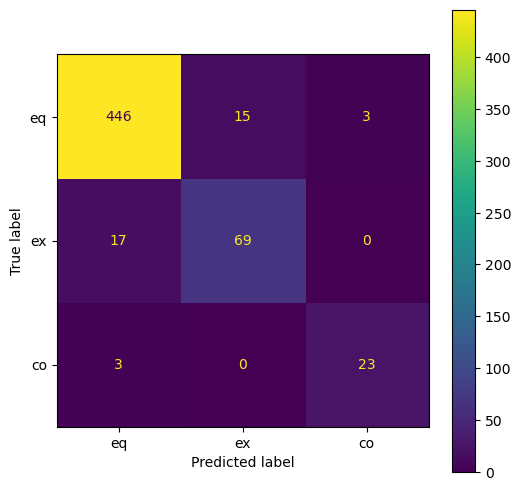

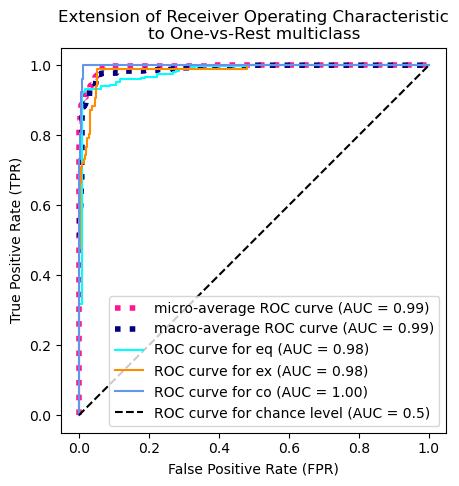

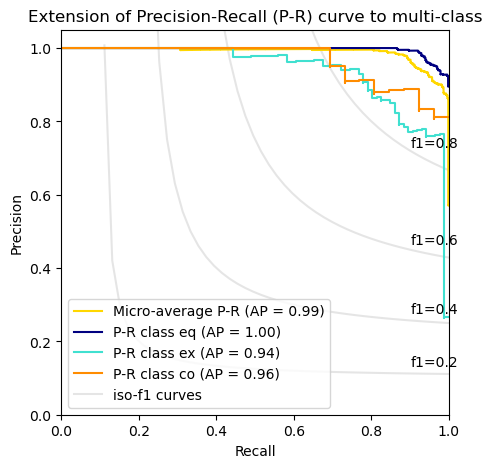

In [55]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_qda_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_qda_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_qda_grid, class_labels, X_train, y_train, X_test, y_test )

# compare all the scores

In [56]:
df_scores.reset_index(inplace=True)
# df_scores.drop(index=5, inplace=True)
# df_scores.reset_index(inplace=True)
df_scores.drop(columns=['index'],inplace=True)
df_scores

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
3,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
4,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
5,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
6,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
8,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120


In [57]:
df_scores.sort_values(by='f1', ascending=False) 

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
5,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
6,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
3,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
4,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
8,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006


In [58]:
df_scores.sort_values(by='recall', ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120
6,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
5,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
8,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
3,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
4,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676


In [59]:
df_scores.sort_values(by='auc', ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
4,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
3,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120
5,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
6,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
8,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029


In [60]:
df_scores.sort_values(by='precision', ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
3,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
4,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
5,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
6,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120
8,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006


In [61]:
df_scores.sort_values(by=['accuracy'], ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
5,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
6,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
3,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
4,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
8,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006


In [62]:
df_scores.sort_values(by=['fit_time'], ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
3,MLP,0.884,0.936,0.906,0.844,0.873,0.988,2.175
4,GPC,0.905,0.929,0.899,0.832,0.862,0.990,0.676
5,RFC,0.985,0.943,0.875,0.952,0.909,0.986,0.427
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.120
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.029
6,LGR,0.983,0.941,0.871,0.957,0.908,0.982,0.009
8,DTC,0.966,0.894,0.750,0.941,0.819,0.980,0.006
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.005
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.005
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005


In [63]:
# select the 6 best classifiers in terms of highest f1-score, recall, and precsion, avg_fit_time
# for each 3 do...

# LGR SVC GPC MLP RFC QDA

In [64]:
# from sklearn.metrics import SCORERS
# sorted(SCORERS.keys())